In [39]:
import random
from math import pi
import scipy.misc
from scipy import signal
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPooling2D
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [54]:
import numpy as np
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


### Shape of data

In [55]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


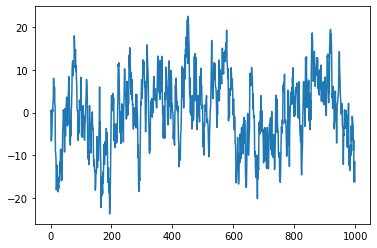

In [5]:
plt.plot(X_train_valid[9,1,:])
plt.show()

In [133]:
#data preprocess
#there are four bands might have information
num_fft=1000
X_train_valid_delta=np.zeros(X_train_valid.shape)
X_train_valid_theta=np.zeros(X_train_valid.shape)
X_train_valid_alpha=np.zeros(X_train_valid.shape)
X_train_valid_beta=np.zeros(X_train_valid.shape)
X_train_valid_gamma=np.zeros(X_train_valid.shape)
X_train_valid_denoise=np.zeros(X_train_valid.shape)

X_test_delta=np.zeros(X_test.shape)
X_test_theta=np.zeros(X_test.shape)
X_test_alpha=np.zeros(X_test.shape)
X_test_beta=np.zeros(X_test.shape)
X_test_gamma=np.zeros(X_test.shape)
X_test_denoise=np.zeros(X_test.shape)
#define four filters in different passband, our sample rate is 250Hz
#Delta is 1-4Hz
#Theta is 4-7Hz
#Alpha is 8-12Hz
#Beta is 12-30Hz
filter_delta = scipy.signal.firwin(1001,[0.008,0.032], pass_zero='bandpass')
filter_theta = scipy.signal.firwin(1001,[0.032,0.056], pass_zero='bandpass')
filter_alpha = scipy.signal.firwin(1001,[0.064,0.096], pass_zero='bandpass')
filter_beta = scipy.signal.firwin(1001,[0.096,0.24], pass_zero='bandpass')
filter_gamma=scipy.signal.firwin(1001,[0.24,0.99],pass_zero='bandpass')
filter_denoise=scipy.signal.firwin(1001,[0.4,0.48],pass_zero='bandstop')

for i in range(X_train_valid.shape[1]):
    for j in range(X_train_valid.shape[0]):
        X_train_valid_delta[j,i,:]=scipy.signal.convolve(X_train_valid[j,i,:],filter_delta,mode='same')
for i in range(X_test.shape[1]):
    for j in range(X_test.shape[0]):
        X_test_delta[j,i,:]=scipy.signal.convolve(X_test[j,i,:],filter_delta,mode='same')
        
for i in range(X_train_valid.shape[1]):
    for j in range(X_train_valid.shape[0]):
        X_train_valid_theta[j,i,:]=scipy.signal.convolve(X_train_valid[j,i,:],filter_theta,mode='same')
for i in range(X_test.shape[1]):
    for j in range(X_test.shape[0]):
        X_test_theta[j,i,:]=scipy.signal.convolve(X_test[j,i,:],filter_theta,mode='same')

for i in range(X_train_valid.shape[1]):
    for j in range(X_train_valid.shape[0]):
        X_train_valid_alpha[j,i,:]=scipy.signal.convolve(X_train_valid[j,i,:],filter_alpha,mode='same')
for i in range(X_test.shape[1]):
    for j in range(X_test.shape[0]):
        X_test_alpha[j,i,:]=scipy.signal.convolve(X_test[j,i,:],filter_alpha,mode='same')
      
for i in range(X_train_valid.shape[1]):
    for j in range(X_train_valid.shape[0]):
        X_train_valid_beta[j,i,:]=scipy.signal.convolve(X_train_valid[j,i,:],filter_beta,mode='same')
for i in range(X_test.shape[1]):
    for j in range(X_test.shape[0]):
        X_test_beta[j,i,:]=scipy.signal.convolve(X_test[j,i,:],filter_beta,mode='same')
        
for i in range(X_train_valid.shape[1]):
    for j in range(X_train_valid.shape[0]):
        X_train_valid_gamma[j,i,:]=scipy.signal.convolve(X_train_valid[j,i,:],filter_gamma,mode='same')
for i in range(X_test.shape[1]):
    for j in range(X_test.shape[0]):
        X_test_gamma[j,i,:]=scipy.signal.convolve(X_test[j,i,:],filter_gamma,mode='same')
        
for i in range(X_train_valid.shape[1]):
    for j in range(X_train_valid.shape[0]):
        X_train_valid_denoise[j,i,:]=scipy.signal.convolve(X_train_valid[j,i,:],filter_denoise,mode='same')
for i in range(X_test.shape[1]):
    for j in range(X_test.shape[0]):
        X_test_denoise[j,i,:]=scipy.signal.convolve(X_test[j,i,:],filter_denoise,mode='same')


trait is 1913
channel is 18


D:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting com

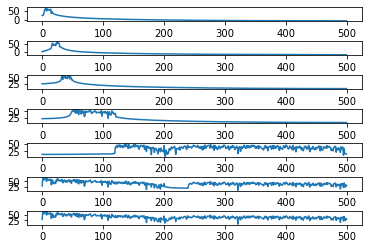

In [13]:
trait=random.randint(0,X_train_valid.shape[0])
channel=random.randint(0,X_train_valid.shape[1])
print("trait is",trait)
print("channel is",channel)

plt.subplot(13,1,1) 
y1=fft(X_train_valid_delta[trait,channel,:],num_fft)
plt.plot(20*np.log10(y1[:500]))

plt.subplot(13,1,3)
y2=fft(X_train_valid_theta[trait,channel,:],num_fft)
plt.plot(20*np.log10(y2[:500]))
plt.subplot(13,1,5)
y3=fft(X_train_valid_alpha[trait,channel,:],num_fft)
plt.plot(20*np.log10(y3[:500]))
plt.subplot(13,1,7)
y4=fft(X_train_valid_beta[trait,channel,:],num_fft)
plt.plot(20*np.log10(y4[:500]))
plt.subplot(13,1,9)
y5=fft(X_train_valid_gamma[trait,channel,:],num_fft)
plt.plot(20*np.log10(y5[:500]))
plt.subplot(13,1,11)
y6=fft(X_train_valid_denoise[trait,channel,:],num_fft)
plt.plot(20*np.log10(y6[:500]))
plt.subplot(13,1,13)
y7=fft(X_train_valid[trait,channel,:],num_fft)
plt.plot(20*np.log10(y7[:500]))
plt.show()

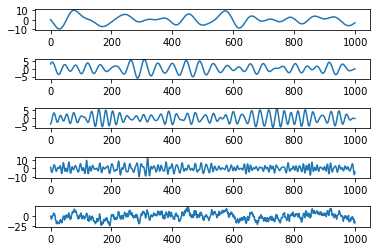

In [9]:


plt.subplot(911)        
plt.plot(X_train_valid_delta[9,1,:])
plt.subplot(913)
plt.plot(X_train_valid_theta[9,1,:])
plt.subplot(915)
plt.plot(X_train_valid_alpha[9,1,:])
plt.subplot(917)
plt.plot(X_train_valid_beta[9,1,:])
plt.subplot(919)
plt.plot(X_train_valid[9,1,:])

plt.show()

In [5]:
def data_prep(X,y,average,noise):
    #maxpooling
    X_max=np.max(X.reshape(X.shape[0], X.shape[1], -1, 2),axis=3)
                 
    output_X=X_max            
        
    #averaging and +noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
                             
    output_X = np.vstack((output_X, X_average))
    output_y = np.hstack((y, y))                            
                             
    return output_X,output_y             


In [152]:
X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,True)

X_train_valid_beta_prep,y_train_valid_prep = data_prep(X_train_valid_beta,y_train_valid,2,True)
X_test_beta_prep,y_test_prep = data_prep(X_test_beta,y_test,2,True)

X_train_valid_gamma_prep,y_train_valid_prep = data_prep(X_train_valid_gamma,y_train_valid,2,True)
X_test_gamma_prep,y_test_prep = data_prep(X_test_gamma,y_test,2,True)

X_train_valid_denoise_prep,y_train_valid_prep = data_prep(X_train_valid_denoise,y_train_valid,2,True)
X_test_denoise_prep,y_test_prep = data_prep(X_test_denoise,y_test,2,True)

print(y_train_valid.shape)
print(y_test_prep.shape)

(2115,)
(886,)


In [75]:
def data_process(X_train_valid_prep,y_train_valid_prep,X_test_prep):
    #splitting data
    ind_valid = np.random.choice(4230, 750, replace=False)
    ind_train = np.array(list(set(range(4230)).difference(set(ind_valid))))

    #creating training and valid data
    (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
    (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
    y_train-=np.min(y_train)
    y_valid-=np.min(y_valid)
   

    #convert labels to one-hot vector
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)


    #add width
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)

    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    return x_train,x_valid,x_test,y_train,y_valid
    

In [153]:
print(y_test_prep.shape)
x_train,x_valid,x_test,y_train,y_valid=data_process(X_train_valid_prep,y_train_valid_prep,X_test_prep)

x_train_beta,x_valid_beta,x_test_beta,y_train_beta,y_valid_beta=data_process(X_train_valid_beta_prep,y_train_valid_prep,X_test_beta_prep)

x_train_gamma,x_valid_gamma,x_test_gamma,y_train_gamma,y_valid_gamma=data_process(X_train_valid_gamma_prep,y_train_valid_prep,X_test_gamma_prep)

x_train_denoise,x_valid_denoise,x_test_denoise,y_train_denoise,y_valid_denoise=data_process(X_train_valid_denoise_prep,y_train_valid_prep,X_test_denoise_prep)


y_test_prep-=np.min(y_test_prep)
print(y_test_prep.shape)
y_test_prep = to_categorical(y_test_prep)

print(y_train_denoise-y_train)
print(y_test_prep.shape)

(886,)
(886,)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
(886, 4)


In [147]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu',input_shape=(500,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 167, 1, 25)       0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 167, 1, 25)       100       
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 167, 1, 25)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 167, 1, 50)        12550     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 56, 1, 50)       

In [166]:
# Building the CNN model using sequential class
basic_cnn_model2 = Sequential()

# Conv. block 1
basic_cnn_model2.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu',input_shape=(500,1,22)))
basic_cnn_model2.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model2.add(BatchNormalization())
basic_cnn_model2.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model2.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model2.add(BatchNormalization())
basic_cnn_model2.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model2.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model2.add(BatchNormalization())
basic_cnn_model2.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model2.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model2.add(BatchNormalization())
basic_cnn_model2.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model2.add(Flatten()) # Flattens the input
basic_cnn_model2.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 167, 1, 25)       0         
 g2D)                                                            
                                                                 
 batch_normalization_28 (Bat  (None, 167, 1, 25)       100       
 chNormalization)                                                
                                                                 
 dropout_28 (Dropout)        (None, 167, 1, 25)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 167, 1, 50)        12550     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 56, 1, 50)       

In [145]:
learning_rate = 5e-3
epochs = 50
cnn_optimizer = Adam(lr=learning_rate)

In [154]:
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
55/55 [==============================] - 3s 48ms/step - loss: 1.6655 - accuracy: 0.3339 - val_loss: 1.5378 - val_accuracy: 0.3547
Epoch 2/50
55/55 [==============================] - 2s 45ms/step - loss: 1.4498 - accuracy: 0.3414 - val_loss: 1.3185 - val_accuracy: 0.4173
Epoch 3/50
55/55 [==============================] - 3s 46ms/step - loss: 1.3785 - accuracy: 0.3733 - val_loss: 1.2831 - val_accuracy: 0.3853
Epoch 4/50
55/55 [==============================] - 3s 46ms/step - loss: 1.3252 - accuracy: 0.3805 - val_loss: 1.2578 - val_accuracy: 0.4160
Epoch 5/50
55/55 [==============================] - 2s 45ms/step - loss: 1.2885 - accuracy: 0.3983 - val_loss: 1.2493 - val_accuracy: 0.4227
Epoch 6/50
55/55 [==============================] - 3s 46ms/step - loss: 1.2706 - accuracy: 0.4138 - val_loss: 1.2292 - val_accuracy: 0.4573
Epoch 7/50
55/55 [==============================] - 2s 45ms/step - loss: 1.2682 - accuracy: 0.4135 - val_loss: 1.2094 - val_accuracy: 0.4720
Epoch 8/50
55

In [167]:
learning_rate = 5e-3
epochs = 50
cnn_optimizer2 = Adam(lr=learning_rate)

In [168]:
basic_cnn_model2.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer2,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model2.fit(x_train_denoise,
             y_train_denoise,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_denoise, y_valid_denoise), verbose=True)

Epoch 1/50
55/55 [==============================] - 5s 55ms/step - loss: 2.3438 - accuracy: 0.3037 - val_loss: 41.2578 - val_accuracy: 0.2773
Epoch 2/50
55/55 [==============================] - 3s 53ms/step - loss: 1.7907 - accuracy: 0.3316 - val_loss: 2.9027 - val_accuracy: 0.2987
Epoch 3/50
55/55 [==============================] - 3s 53ms/step - loss: 1.6042 - accuracy: 0.3822 - val_loss: 1.8285 - val_accuracy: 0.3800
Epoch 4/50
55/55 [==============================] - 3s 53ms/step - loss: 1.4425 - accuracy: 0.4342 - val_loss: 1.5011 - val_accuracy: 0.4400
Epoch 5/50
55/55 [==============================] - 3s 53ms/step - loss: 1.3315 - accuracy: 0.4537 - val_loss: 1.3143 - val_accuracy: 0.4653
Epoch 6/50
55/55 [==============================] - 3s 53ms/step - loss: 1.3151 - accuracy: 0.4555 - val_loss: 1.2037 - val_accuracy: 0.4880
Epoch 7/50
55/55 [==============================] - 3s 53ms/step - loss: 1.2306 - accuracy: 0.4937 - val_loss: 1.0972 - val_accuracy: 0.5173
Epoch 8/50
5

In [170]:
## Testing the basic CNN model
print(x_test_denoise.shape)
print(y_test_prep.shape)

cnn_score = basic_cnn_model.evaluate(x_test,y_test_prep, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

(886, 500, 1, 22)
(886, 4)
Test accuracy of the basic CNN model: 0.5981941223144531


In [169]:
## Testing the basic CNN model
print(x_test_denoise.shape)
print(y_test_prep.shape)

cnn_score = basic_cnn_model2.evaluate(x_test_denoise,y_test_prep, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

(886, 500, 1, 22)
(886, 4)
Test accuracy of the basic CNN model: 0.6602708697319031
